# Pozyx Data - Quick Explorations

Some explorations, building off what's in DataTransform.

In [1]:
%matplotlib inline

import json
import time
from IPython import display

import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from scipy.signal import medfilt

## Data Loading 

In [2]:
def load_posyx_file(f_name):
    """Helper function to load data."""
    
    # Update this list to specify which columns you want to keep
    keep_cols = ['tagId', 'timestamp', 'x', 'y', 'z', 'latency']

    # Load the data
    df = pd.read_json(f_name, lines=True, orient='records')

    # Grab the data column, unpack and add all the embedded jsons
    data_df = pd.read_json(df.pop('data').to_json(), orient='index')
    for col in ['coordinates', 'metrics', 'orientation']:
        temp = pd.read_json(data_df[col].to_json(), orient='index')
        df = pd.concat([df, temp], axis=1, join_axes=[df.index])
        
    # Select columns to return
    df = df[keep_cols]

    return df

In [3]:
# Load a test data file
df = load_posyx_file('pilot_3_3.json')

## Check Tags

In [4]:
# Check how many tags there are, and their IDs
tags = set(df['tagId'].values)
print('There are {} tags'.format(len(tags)))
print('The tag IDs are: {}'.format(*tags))

There are 2 tags
The tag IDs are: 26395


In [5]:
# Use a dictionary to label tags
tag_dict = {'participant' : 26395, 
            'confederate' : 26382}

In [6]:
# Example: Use the lab dictionary to loop through the raw data, and grab data from a specific tag
for person in tag_dict.keys():
    print(person)
    print(df[df['tagId'] == tag_dict[person]].head())
    print('\n')

participant
   tagId                     timestamp       x       y    z  latency
1  26395 2018-10-30 20:36:46.437000036  2217.0  -866.0  0.0     46.7
3  26395 2018-10-30 20:36:46.562999964  2218.0  -810.0  0.0     44.7
5  26395 2018-10-30 20:36:46.671999931  2271.0  -864.0  0.0     43.7
7  26395 2018-10-30 20:36:46.766000032  2195.0 -1169.0  0.0     45.8
9  26395 2018-10-30 20:36:46.884000063  2226.0 -1106.0  0.0     50.3


confederate
   tagId                     timestamp       x      y    z  latency
0  26382 2018-10-30 20:36:46.380000114  3123.0   71.0  0.0     48.4
2  26382 2018-10-30 20:36:46.512000083  3103.0  116.0  0.0     45.6
4  26382 2018-10-30 20:36:46.611000061  3129.0  126.0  0.0     44.7
6  26382 2018-10-30 20:36:46.719000101  3200.0    4.0  0.0     44.9
8  26382 2018-10-30 20:36:46.815000057  3141.0  123.0  0.0     51.7




In [7]:
# Here, use the dictionary to manage the data, creating a dictionary of data for each tag
tag_data = {}
for tag_name, tag_id in tag_dict.items():
    tag_data[tag_name] = df[df['tagId'] == tag_id]

In [8]:
# Check the dictionary of data, per tag
for name, data in tag_data.items():
    print(name)
    print(data.head())
    print('\n')

participant
   tagId                     timestamp       x       y    z  latency
1  26395 2018-10-30 20:36:46.437000036  2217.0  -866.0  0.0     46.7
3  26395 2018-10-30 20:36:46.562999964  2218.0  -810.0  0.0     44.7
5  26395 2018-10-30 20:36:46.671999931  2271.0  -864.0  0.0     43.7
7  26395 2018-10-30 20:36:46.766000032  2195.0 -1169.0  0.0     45.8
9  26395 2018-10-30 20:36:46.884000063  2226.0 -1106.0  0.0     50.3


confederate
   tagId                     timestamp       x      y    z  latency
0  26382 2018-10-30 20:36:46.380000114  3123.0   71.0  0.0     48.4
2  26382 2018-10-30 20:36:46.512000083  3103.0  116.0  0.0     45.6
4  26382 2018-10-30 20:36:46.611000061  3129.0  126.0  0.0     44.7
6  26382 2018-10-30 20:36:46.719000101  3200.0    4.0  0.0     44.9
8  26382 2018-10-30 20:36:46.815000057  3141.0  123.0  0.0     51.7




In [9]:
# Note: sets are a useful data structure for 
{'confederate', 'participant'} - {'confederate'}

{'participant'}

In [10]:
# Distance formula (note: copied from data transform)
import math

def distance(x1, y1, x2, y2):
    
    dist_x = x1 - x2
    dist_y = y1 - y2
    
    distance = math.sqrt(dist_x**2 + dist_y**2)
    
    return distance

In [19]:
# Get a set of all tag names
tag_names = set(tag_dict.keys())

#all_dists = {name : [] for name in tag_names}

# Loop through each tag
for name, data in tag_data.items():
    
    print('Current tag: {}'.format(name))
    
    # Get a set of all other tags
    other_tags = tag_names - set([name])
    
    # Loop across other tags
    for other_tag in other_tags:
        
        temp = []
        
        # This is one way to loop across dataframes for each tag together
        for (i1, row1), (i2, row2) in zip(tag_data[name].iterrows(), tag_data[other_tag].iterrows()):
            
            # Calculate the distance of the current tag, to the current other tag
            dist = distance(*row1[['x', 'y']], *row2[['x', 'y']])
            
            # This is just to cut off printing after a few rows
            if i1 < 10:
                print('\tDistance of {} to {} is \t{}'.format(name, other_tag, dist))
                
            temp.append(dist)
        
        tag_data[name]['DistTo'+other_tag] = temp
    
    print('\n')

Current tag: participant
	Distance of participant to confederate is 	1303.3821388986423
	Distance of participant to confederate is 	1280.898512763599
	Distance of participant to confederate is 	1310.0625939244278
	Distance of participant to confederate is 	1544.6533591715652
	Distance of participant to confederate is 	1532.2095156994685


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy




Current tag: confederate
	Distance of confederate to participant is 	1303.3821388986423
	Distance of confederate to participant is 	1280.898512763599
	Distance of confederate to participant is 	1310.0625939244278
	Distance of confederate to participant is 	1544.6533591715652
	Distance of confederate to participant is 	1532.2095156994685




## Exploring Time Stamps

In [20]:
# Note: manipulating time stamps
d1 = df.timestamp.values[0]
d2 = df.timestamp.values[1]

print(d1 - d2)

-56999922 nanoseconds


## Median Filter to Smooth Distance Data

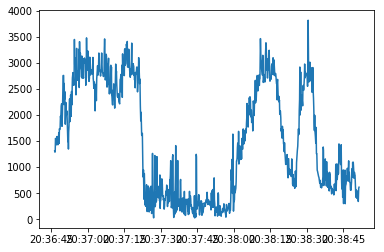

In [21]:
plt.plot(tag_data['confederate']['timestamp'], tag_data['confederate']['DistToparticipant'])

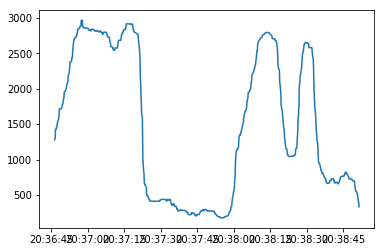

In [22]:
plt.plot(tag_data['confederate']['timestamp'],
         medfilt(tag_data['confederate']['DistToparticipant'], kernel_size=51))

## NOTE: check / explore animations to play movement data over time

This doesn't seem to be working as it - but there should be some ways to animate data / plots over time.

In [15]:
# ## Example animation: plot data across time

# d1 = [1, 1, 1, 1]
# d2 = [1, 2, 3, 4]

# for dd, ee in zip(d1, d2):
    
#     plt.figure()
#     plt.plot(dd, ee, '.')
#     plt.xlim(1, 4); plt.ylim(1, 4);
#     display.display(plt.gcf())
#     time.sleep(1)
#     display.clear_output(True)
#     #plt.show()